In [1]:
import os
os.getcwd()

'c:\\Users\\ebaca\\Desktop\\Interacting Galaxies Project'

##### packages galore

In [2]:
import matplotlib.pyplot as plt

# this is not a real package just a collection of functions i made in a .py file 
# this also includes the convenience_functions.py file that was given by Tuttle
from funcrefs import fnrefs as rfs
from funcrefs import convenience_functions as cf
from funcrefs import PhotAnnulus as phan

from astropy.io import fits
from astropy.wcs import WCS
from ccdproc import Combiner
from astropy.nddata import CCDData
import re
import astropy.units as u
import numpy as np
import astropy.visualization as vis
import warnings
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle

import photutils as pu
from astropy.stats import sigma_clipped_stats, SigmaClip
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry, ApertureStats
import photutils.background as pb

### notes for myself

collapse to ignore

In [3]:
# from WCS documentation: https://docs.astropy.org/en/stable/wcs/#a-simple-example
    # fn = get_pkg_data_filename('data/j94f05bgq_flt.fits', package='astropy.wcs.tests')
    # f = fits.open(fn)
    # w = WCS(f[1].header)
    # sky = w.pixel_to_world(30, 40)
    # x, y = w.world_to_pixel(sky)
# LOL idk what i'm doing, will need to figure this out

creating master files for biases, darks, and flats to use in data reduction

stack with wcs position to crop images, not x/y position

i.e. stack as a function of position, not CCD position, so it's okay if they aren't lined up

use wcs to translate pixel to coordinate system then combiner to combine the images

- aperture photometry over psf? 
    - shredding: breaks up an object into smaller objects
- sky background/annular photometry
    - aperture radius
- data reduction with ML --> maybe but is it overengineering?
- then once pic looks good then can go forward and start analysis
    - emission & absorption lines?
    - subtract average brightness from image data to isolte h-alpha lines
    - compare the brightness of h-alpha lines in ngc 4567 and m 58 to see how star formation rates are affected
- remember end goal is to get flux data to analyse star formation in interacting galaxies

## creating stacks/accessing files

if using rfs.create_stack(), make sure to call normalize=True for the flats! this will make sure they are normalized before stacking. 

otherwise, the parameter doesn't need to be called

#### creating stacks & writing to files
collapse to ignore

In [4]:
# # stacking calibration files
# # commenting this out since it only needs to be run once

# # BIASES
# rfs.create_stack('biases/', keyword='Bias_', writeto='biases/master_bias.fits', overwrite=True)

# # DARKS
# rfs.create_stack('darks/', keyword='Dark_', writeto='darks/master_dark.fits', overwrite=True)

# # G FILTER FLATS
# rfs.create_stack('flats/g flats/', keyword='domeflat', writeto='flats/g flats/master_gfilter.fits', overwrite=True, normalize = True)

# # Ha FILTER FLATS
# rfs.create_stack('flats/ha flats/', keyword='domeflat', writeto='flats/ha flats/master_hafilter.fits', overwrite=True, normalize = True)

# # I FILTER FLATS
# rfs.create_stack('flats/i flats/', keyword='domeflat', writeto='flats/i flats/master_ifilter.fits', overwrite=True, normalize = True)

# # R FILTER FLATS
# rfs.create_stack('flats/r flats/', keyword='domeflat', writeto='flats/r flats/master_rfilter.fits', overwrite=True, normalize = True)

In [5]:
# # stacking NGC 4567 raw data files and calibrating
# # commenting this out since it only needs to be run once

# cal_ngc4567 = {
#     'g': rfs.create_stack('NGC 4567/raw data/', keyword = '_g_'),
#     'ha': rfs.create_stack('NGC 4567/raw data/', keyword = '_Ha_'),
#     'r': rfs.create_stack('NGC 4567/raw data/', keyword = '_r_'),
#     'i': rfs.create_stack('NGC 4567/raw data/', keyword = '_i_')
# }

# for filter in ['g', 'ha', 'r', 'i']:
    
#     calibrated_data = ((cal_ngc4567[filter] - bias - dark) / flats[filter])
#     fits.writeto(f'NGC 4567/calibrated_{filter}.fits', calibrated_data, overwrite=True)

In [6]:
# # stacking M 58 raw data files and calibrating
# # commenting this out since it only needs to be run once

# cal_m58 = {
#     'g': rfs.create_stack('M 58/raw data/', keyword = '_g_'),
#     'ha': rfs.create_stack('M 58/raw data/', keyword = '_Ha_'),
#     'r': rfs.create_stack('M 58/raw data/', keyword = '_r_')
# }

# for filter in ['g', 'ha', 'r']:
    
#     calibrated_data = ((cal_m58[filter] - bias - dark) / flats[filter])
#     fits.writeto(f'M 58/calibrated_{filter}.fits', calibrated_data, overwrite=True)

#### accessing stack files

In [7]:
bias = fits.open('biases/master_bias.fits')[0].data

dark = fits.open('darks/master_dark.fits')[0].data

flats = { # only flats need to be normalized
    'g': fits.open('flats/g flats/master_gfilter.fits')[0].data,
    'ha': fits.open('flats/ha flats/master_hafilter.fits')[0].data,
    'r': fits.open('flats/r flats/master_rfilter.fits')[0].data,
    'i': fits.open('flats/i flats/master_ifilter.fits')[0].data
}

In [8]:
ngc4567 = {
    'g': fits.open('NGC 4567/calibrated_g.fits')[0].data,
    'ha': fits.open('NGC 4567/calibrated_ha.fits')[0].data,
    'r': fits.open('NGC 4567/calibrated_r.fits')[0].data,
    'i': fits.open('NGC 4567/calibrated_i.fits')[0].data
}

m58 = {
    'g': fits.open('M 58/calibrated_g.fits')[0].data,
    'ha': fits.open('M 58/calibrated_ha.fits')[0].data,
    'r': fits.open('M 58/calibrated_r.fits')[0].data
}

## assessing calibrations NGC 4567
no longer needed

In [9]:
raw_ngc4567 = {
    'g': rfs.create_stack('NGC 4567/raw data/', keyword = '_g_'),
    'ha': rfs.create_stack('NGC 4567/raw data/', keyword = '_Ha_'),
    'r': rfs.create_stack('NGC 4567/raw data/', keyword = '_r_'),
    'i': rfs.create_stack('NGC 4567/raw data/', keyword = '_i_')
}

[]

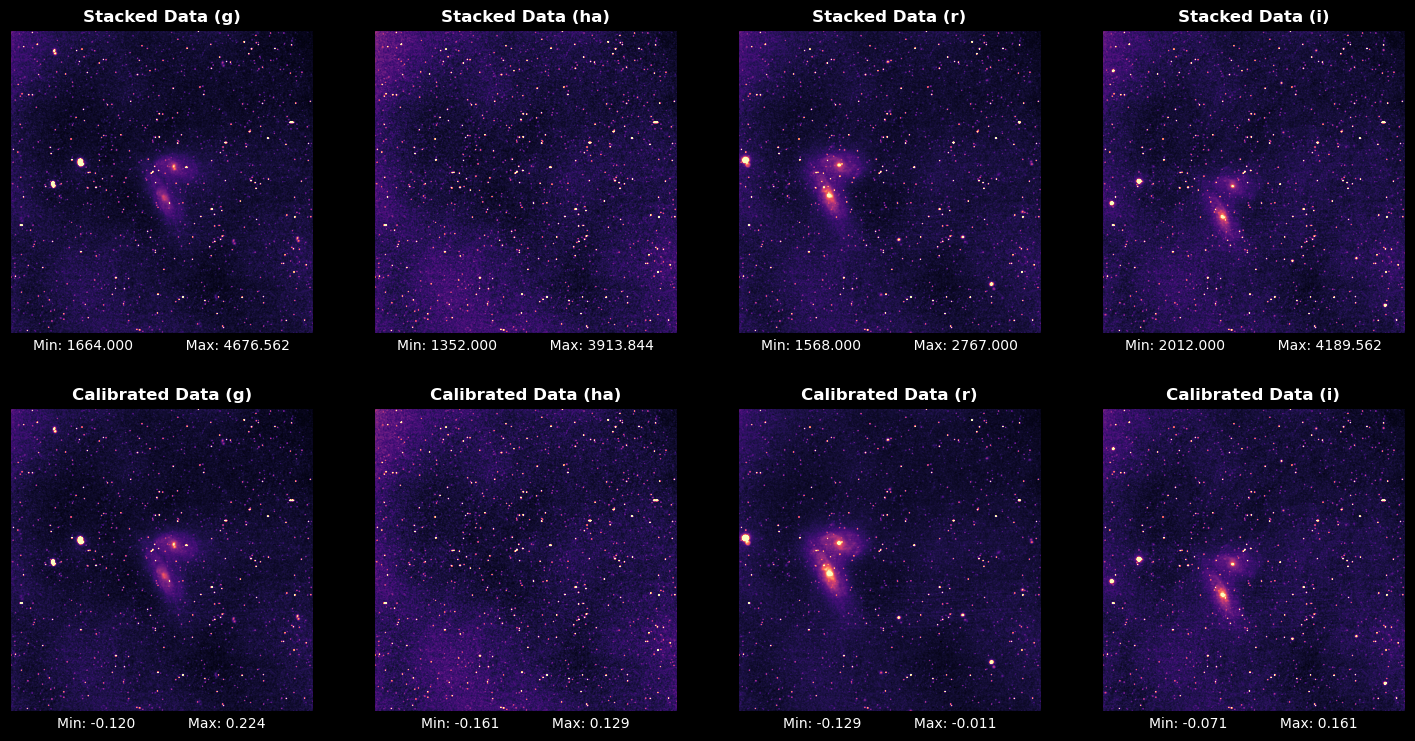

In [10]:
fig, axs = plt.subplots(2, 4, figsize=(18, 9), facecolor='black')

for i, filter in enumerate(['g', 'ha', 'r', 'i']):

    # raw stacked data --------------------------------
    raw_data = raw_ngc4567[filter]

    vis_vmin, vis_vmax = np.percentile(raw_data, [1, 99.75])
    norm = vis.ImageNormalize(raw_data, vmin=vis_vmin, vmax=vis_vmax, interval=vis.ZScaleInterval(), stretch=vis.LinearStretch())

    axs[0, i].imshow(raw_data, cmap='magma', norm=norm, interpolation='gaussian')
    axs[0, i].set_title(f'Stacked Data ({filter})', weight='bold', color='white')
    axs[0, i].set_xlabel(f'Min: {vis_vmin:.3f}            Max: {vis_vmax:.3f}', color='white')

    # calibrated data --------------------------------
    calibrated_data = ngc4567[filter]

    vis_vmin, vis_vmax = np.percentile(calibrated_data, [1, 99.75])
    norm = vis.ImageNormalize(calibrated_data, vmin=vis_vmin, vmax=vis_vmax, interval=vis.ZScaleInterval(), stretch=vis.LinearStretch())

    axs[1, i].imshow(calibrated_data, cmap='magma', norm=norm, interpolation='gaussian')
    axs[1, i].set_title(f'Calibrated Data ({filter})', weight='bold', color='white')
    axs[1, i].set_xlabel(f'Min: {vis_vmin:.3f}            Max: {vis_vmax:.3f}', color='white')

plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])

## assessing calibrations M 58
no longer needed

In [11]:
raw_m58 = {
    'g': rfs.create_stack('M 58/raw data/', keyword = '_g_'),
    'ha': rfs.create_stack('M 58/raw data/', keyword = '_Ha_'),
    'r': rfs.create_stack('M 58/raw data/', keyword = '_r_')
}

[]

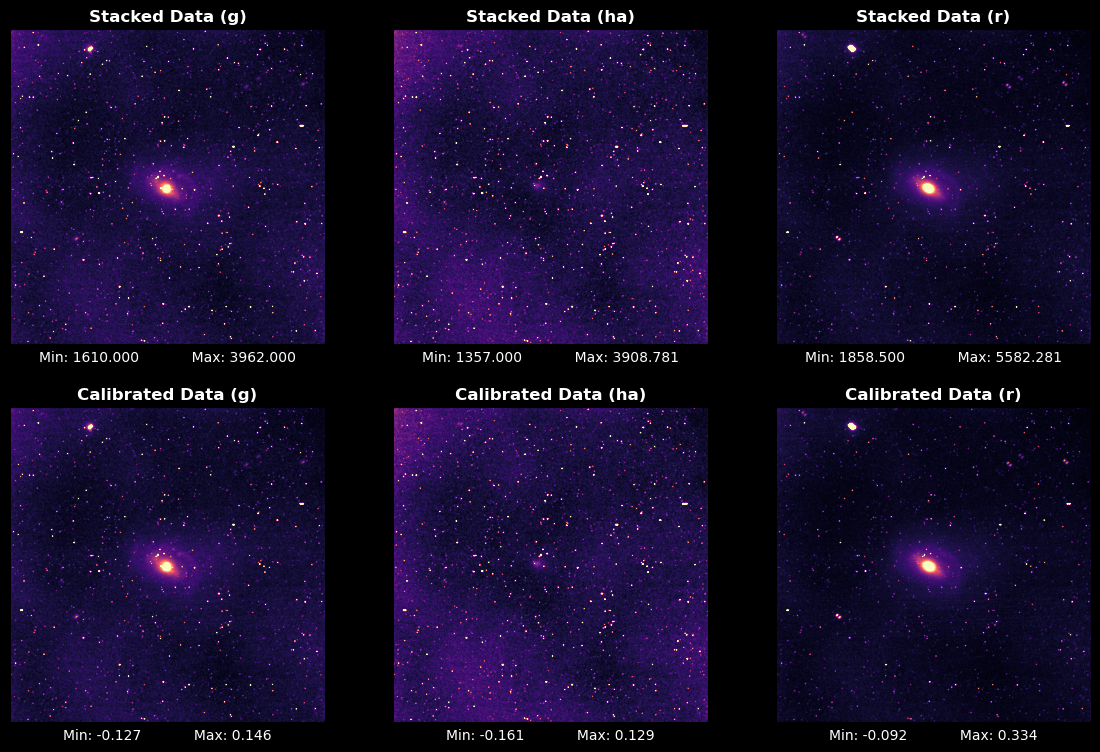

In [12]:
fig, axs = plt.subplots(2, 3, figsize=(14, 9), facecolor='black')

for i, filter in enumerate(['g', 'ha', 'r']):

    # raw stacked data --------------------------------
    raw_data = raw_m58[filter]

    vis_vmin, vis_vmax = np.percentile(raw_data, [1, 99.75])
    norm = vis.ImageNormalize(raw_data, vmin=vis_vmin, vmax=vis_vmax, interval=vis.ZScaleInterval(), stretch=vis.LinearStretch())

    axs[0, i].imshow(raw_data, cmap='magma', norm=norm, interpolation='gaussian')
    axs[0, i].set_title(f'Stacked Data ({filter})', weight='bold', color='white')
    axs[0, i].set_xlabel(f'Min: {vis_vmin:.3f}            Max: {vis_vmax:.3f}', color='white')

    # calibrated data --------------------------------
    calibrated_data = m58[filter]

    vis_vmin, vis_vmax = np.percentile(calibrated_data, [1, 99.75])
    norm = vis.ImageNormalize(calibrated_data, vmin=vis_vmin, vmax=vis_vmax, interval=vis.ZScaleInterval(), stretch=vis.LinearStretch())

    axs[1, i].imshow(calibrated_data, cmap='magma', norm=norm, interpolation='gaussian')
    axs[1, i].set_title(f'Calibrated Data ({filter})', weight='bold', color='white')
    axs[1, i].set_xlabel(f'Min: {vis_vmin:.3f}            Max: {vis_vmax:.3f}', color='white')

plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])